In [1]:
import numpy as np
import keras
from keras.preprocessing import image
import os
from keras.utils import Sequence
from PIL import Image


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
base_path = '../tiny-imagenet-200/train'
#Process Validation Data
base_path_valid = '../tiny-imagenet-200/val'
st = '../tiny-imagenet-200/val/images/'

BATCH_SIZE = 128
IMG_DIM = (224,224)

In [3]:

def preprocess_input(x,mode='tf'):
        """
            - tf: will scale pixels between -1 and 1,
                sample-wise.
            - torch: will scale pixels between 0 and 1 and then
                will normalize each channel with respect to the
                ImageNet dataset.
                
        """
        if mode=='tf':
            x = x/127.5
            x -= 1
            return x
        
        if mode=='torch':
            mean = [0.485,0.456,0.406]
            std = [0.229,0.224,0.225]
            x /= 255.0
            x[...,0] -= mean[0]
            x[...,1] -= mean[1]
            x[...,2] -= mean[2]
            
            x[...,0] /= std[0]
            x[...,1] /= std[1]
            x[...,2] /= std[2]
            
        return x
        

In [4]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=None, n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, f in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open(f)
            img = img.resize(self.dim)
            img = img.convert('RGB')
            X[i,] = preprocess_input(np.array(img,dtype=np.float32))
            img.close()
            
            
            # Store class
            y[i] = self.labels[f]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [5]:
partition = {
    'train': [],
    'validation': []
}
labels = {}
class_ids = {}
cnt = 0

In [6]:
#Process Training Data

In [7]:
for label in os.listdir(base_path):
    temp = os.path.join(base_path, label)
    
    if class_ids.get(label) is None:
        class_ids[label] = cnt
        cnt += 1
    
    img_fldr_path = os.path.join(temp, 'images')
    for imgs in os.listdir(img_fldr_path):
        ID = os.path.join(img_fldr_path, imgs)
        partition['train'].append( ID )
        labels[ID] = class_ids[label]

In [8]:
NO_OF_CLASSES = len((os.listdir(base_path)))

In [9]:
with open(os.path.join(base_path_valid,"val_annotations.txt")) as f:
    
    lines = f.readlines()
    for line in lines:
        tokens = line.split()
        img_name = tokens[0]
        img_label = tokens[1]
        ID = os.path.join(st,img_name)
        partition['validation'].append(ID)
        labels[ID] = class_ids[img_label]

In [10]:

train_generator = DataGenerator(batch_size=128,dim=(224,224),n_channels=3,list_IDs=partition['train'],
                                labels=labels,n_classes=NO_OF_CLASSES)

val_generator = DataGenerator(batch_size=128,dim=(224,224),n_channels=3,list_IDs=partition['train'],
                                labels=labels,n_classes=NO_OF_CLASSES)


In [11]:
"""
for i,(x,y) in enumerate(train_generator):
    #print(np.argmax(y,axis=1))
    print(np.argmax(y,axis=-1))
    print(x.shape,y.shape)
    break   
"""

'\nfor i,(x,y) in enumerate(train_generator):\n    #print(np.argmax(y,axis=1))\n    print(np.argmax(y,axis=-1))\n    print(x.shape,y.shape)\n    break   \n'

### Augmentation Based Approach

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [17]:
train_image_gen = ImageDataGenerator(
    rescale= 1/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True,
)
test_gen = ImageDataGenerator(rescale=1./255)

In [19]:
train_gen = train_image_gen.flow_from_directory(
    base_path,
    target_size =((224,224)),
    batch_size = 128,
    class_mode = 'categorical'
)


Found 100000 images belonging to 200 classes.


In [25]:
import matplotlib.pyplot as plt

(128, 224, 224, 3) (128, 200)


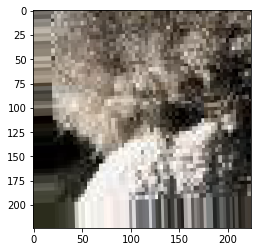

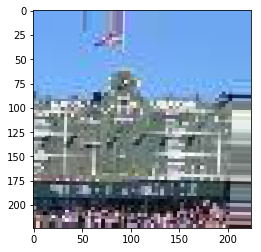

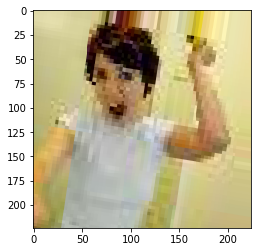

In [34]:
for i,(x,y) in enumerate(train_gen):
    print(x.shape,y.shape)
    
    plt.imshow(x[0])
    plt.show()
    plt.imshow(x[1])
    plt.show()
    plt.imshow(x[2])
    plt.show()
    break